In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bangla-newspaper-dataset/data_v2/data_v2.json
/kaggle/input/bangla-newspaper-dataset/data/data.json


In [2]:
%%capture
%pip install -U bitsandbytes
%pip install -U transformers
%pip install -U accelerate
%pip install -U peft
%pip install -U trl

In [3]:
!pip install wandb
#!wandb login

In [4]:
import wandb

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wb_token = user_secrets.get_secret("wandb")

wandb.login(key=wb_token)
run = wandb.init(
    project='Qwen 2.0 Fine-tune on Newspaper Dataset', 
    job_type="training", 
    anonymous="allow"
)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: cse-mahmud-evan (cse-mahmud-evan-ccn-university-of-science-and-technology). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.18.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20241003_122137-w8te5nv7
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run exalted-firefly-6
wandb: ⭐️ View project at https://wandb.ai/cse-mahmud-evan-ccn-university-of-science-and-technology/Qwen%202.0%20Fine-tune%20on%20Newspaper%20Dataset
w

In [5]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import bitsandbytes as bnb
import torch
import torch.nn as nn
import transformers
from peft import LoraConfig, PeftConfig
from trl import SFTTrainer
from trl import setup_chat_format
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
    logging
)
from sklearn.metrics import (

    accuracy_score,
    classification_report,
    confusion_matrix   
)
from sklearn.model_selection import train_test_split

In [6]:
import numpy as np
import pandas as pd

data = pd.read_json('/kaggle/input/bangla-newspaper-dataset/data_v2/data_v2.json')
data.head()

,author,category,category_bn,published_date,modification_date,tag,comment_count,title,url,content
0,গাজীপুর প্রতিনিধি,bangladesh,বাংলাদেশ,"০৪ জুলাই ২০১৩, ২৩:২৬","০৪ জুলাই ২০১৩, ২৩:২৭",[গাজীপুর],0,"কালিয়াকৈরে টিফিন খেয়ে ৫০০ শ্রমিক অসুস্থ, বিক...",http://www.prothom-alo.com/bangladesh/article/...,গাজীপুরের কালিয়াকৈর উপজেলার তেলিরচালা এলাকায়...
1,অনলাইন ডেস্ক,sports,খেলা,"০৪ জুলাই ২০১৩, ২৩:০৯","০৪ জুলাই ২০১৩, ২৩:১১",[টেনিস],0,সেমিফাইনাল বাধাও পেরিয়ে গেলেন লিসিকি,http://www.prothom-alo.com/sports/article/19028,এবারের উইম্বলডনটা স্মরণীয় করে রাখার মিশনেই যে...
2,নিজস্ব প্রতিবেদক,bangladesh,বাংলাদেশ,"০৪ জুলাই ২০১৩, ২২:২৫","০৪ জুলাই ২০১৩, ২৩:১২",[রাজনীতি],0,সংসদে খালেদার অভিযোগের জবাব দিয়েছে ভারত,http://www.prothom-alo.com/bangladesh/article/...,জাতীয় সংসদে বিএনপি চেয়ারপারসন ও বিরোধীদলীয় ...
3,অনলাইন ডেস্ক,technology,বিজ্ঞান ও প্রযুক্তি,"০৪ জুলাই ২০১৩, ২১:৩৭","০৪ জুলাই ২০১৩, ২১:৪৫",[গবেষণা],0,পাসওয়ার্ড ভুলে যান!,http://www.prothom-alo.com/technology/article/...,সহজ পাসওয়ার্ডের কারণে অনলাইন অ্যাকাউন্ট সহজেই...
4,অনলাইন ডেস্ক,technology,বিজ্ঞান ও প্রযুক্তি,"০৪ জুলাই ২০১৩, ২১:৩৫","০৪ জুলাই ২০১৩, ২১:৩৭",[কম্পিউটার],0,চলে গেলেন মাউস উদ্ভাবক,http://www.prothom-alo.com/technology/article/...,কম্পিউটার মাউসের উদ্ভাবক ডগলাস অ্যাঙ্গেলবার্ট ...


In [7]:
len(data.columns)

10

In [8]:
ndf = data[['content','category']]

In [9]:
ndf.shape

(408471, 2)

In [10]:
ndf.duplicated().sum()

1567

In [11]:
ndf.drop_duplicates(inplace= True)

/tmp/ipykernel_23/3272145479.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndf.drop_duplicates(inplace= True)


In [12]:
ndf.shape

(406904, 2)

In [13]:
ndf.category.unique()

array(['bangladesh', 'sports', 'technology', 'entertainment',
       'international', 'economy', 'life-style', 'opinion', 'education'],
      dtype=object)

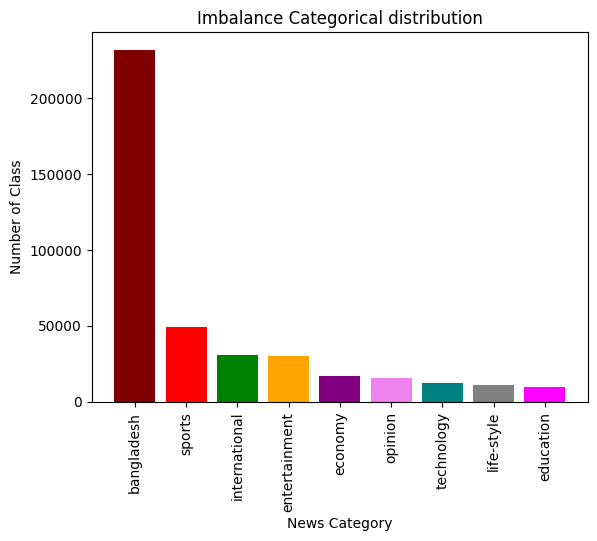

In [14]:
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt


color_palette = ['maroon', 'red', 'green', 'orange', 'purple', 'violet','teal','gray','magenta']

labels = ndf['category'].value_counts().index
values = ndf['category'].value_counts().values

plt.bar(labels,values, color = color_palette)
plt.title("Imbalance Categorical distribution")
plt.xticks(rotation=90)
plt.xlabel('News Category')
plt.ylabel('Number of Class')



plt.show()

In [15]:
ndf.head()

,content,category
0,গাজীপুরের কালিয়াকৈর উপজেলার তেলিরচালা এলাকায়...,bangladesh
1,এবারের উইম্বলডনটা স্মরণীয় করে রাখার মিশনেই যে...,sports
2,জাতীয় সংসদে বিএনপি চেয়ারপারসন ও বিরোধীদলীয় ...,bangladesh
3,সহজ পাসওয়ার্ডের কারণে অনলাইন অ্যাকাউন্ট সহজেই...,technology
4,কম্পিউটার মাউসের উদ্ভাবক ডগলাস অ্যাঙ্গেলবার্ট ...,technology


In [16]:
!pip install imblearn

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [17]:
from imblearn.under_sampling import RandomUnderSampler

A = ndf.drop('category',axis = 1)
b = ndf['category']

rus = RandomUnderSampler()

A_resampled, b_resampled = rus.fit_resample(A,b)

resampled_df = pd.DataFrame(A_resampled,columns = A.columns)
resampled_df['category'] = b_resampled

resampled_df = resampled_df.sample(frac = 1, random_state = 85).reset_index (drop=True)

In [18]:
resampled_df.head()

,content,category
0,একজন সফটওয়্যার উদ্যোক্তা কেমন মানুষ হতে পারেন?...,technology
1,"আবাসিক হোটেল, রেস্তোরাঁ, ফাস্ট ফুড, মিষ্টান্ন ...",economy
2,"ছুটির দিন। ভোরে মেয়ে এসে ঢুকল আমার ঘরে।‘বাবা,...",life-style
3,জামায়াত-শিবিরের নৃশংস বর্বরতায় নীলফামারীজুড়ে চ...,opinion
4,"অধ্যায়-৩ প্রিয় শিক্ষার্থী, আজ প্রাথমিক বিজ্ঞা...",education


In [19]:
resampled_df.shape

(86868, 2)

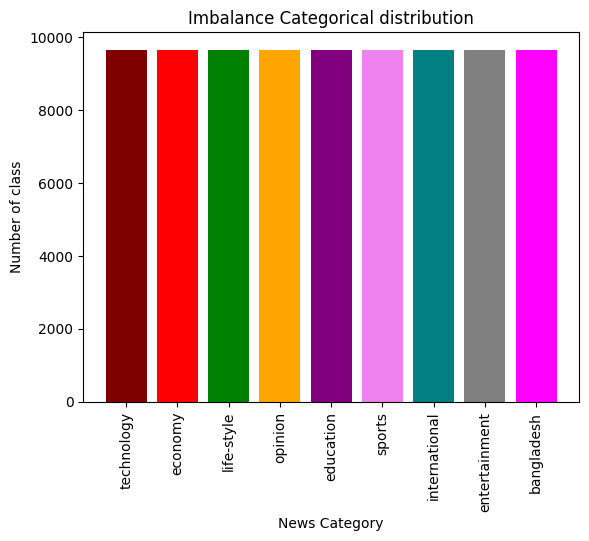

In [20]:
#category distribution
labels = resampled_df['category'].value_counts().index
values = resampled_df['category'].value_counts().values

color_palette = ['maroon', 'red', 'green', 'orange', 'purple', 'violet','teal','gray','magenta']

#plot bar chart
plt.bar(labels,values, color = color_palette)
plt.title('Imbalance Categorical distribution')
plt.xticks(rotation=90)
plt.xlabel('News Category')
plt.ylabel('Number of class')
plt.show()

In [21]:
resampled_df['category'].value_counts()

category
technology       9652
economy          9652
life-style       9652
opinion          9652
education        9652
sports           9652
international    9652
entertainment    9652
bangladesh       9652
Name: count, dtype: int64

In [22]:
df = resampled_df.sample(frac= 1, random_state = 48).reset_index(drop=True).head(1000)
df.head()

,content,category
0,যদি বেশির ভাগ জরিপের আভাস সত্যি বলে প্রমাণিত হ...,international
1,ফুটবলের কাছে মেসির একটি বিশ্বকাপ পাওনা আছে। হো...,sports
2,বিশ্বজুড়ে ট্যাবলেট কম্পিউটার বা ট্যাব বিক্রি ...,technology
3,প্রধানমন্ত্রী মনমোহন সিং একজন ট্র্যাজিক ব্যক্ত...,international
4,আজ টিভিতে যে খেলাগুলো দেখতে পাবেন:আইপিএলচ্যানে...,sports


In [23]:
train_size = 0.8
val_size = 0.1

train_end = int(train_size * len(df)) 
val_end = train_end + int(val_size * len(df))

In [24]:
X_train = df[:train_end]
X_val = df[train_end:val_end]
X_test = df[val_end:]

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(800, 2)
(100, 2)
(100, 2)


In [25]:
# Define the prompt generation functions
def generate_prompt(data_point):
    return f"""
            Classify the text into bangladesh, sports, technology, entertainment,international, economy, life-style, opinion, education and return the answer as the corresponding newpapers news category.
text: {data_point["content"]}
label: {data_point["category"]}""".strip()

def generate_test_prompt(data_point):
    return f"""
            Classify the text into bangladesh, sports, technology, entertainment,international, economy, life-style, opinion, education and return the answer as the corresponding newpapers news category.
text: {data_point["content"]}
label: """.strip()

In [26]:
X_train.loc[:,'text'] = X_train.apply(generate_prompt,axis = 1)
X_train.head()

/tmp/ipykernel_23/605730108.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.loc[:,'text'] = X_train.apply(generate_prompt,axis = 1)


,content,category,text
0,যদি বেশির ভাগ জরিপের আভাস সত্যি বলে প্রমাণিত হ...,international,"Classify the text into bangladesh, sports, tec..."
1,ফুটবলের কাছে মেসির একটি বিশ্বকাপ পাওনা আছে। হো...,sports,"Classify the text into bangladesh, sports, tec..."
2,বিশ্বজুড়ে ট্যাবলেট কম্পিউটার বা ট্যাব বিক্রি ...,technology,"Classify the text into bangladesh, sports, tec..."
3,প্রধানমন্ত্রী মনমোহন সিং একজন ট্র্যাজিক ব্যক্ত...,international,"Classify the text into bangladesh, sports, tec..."
4,আজ টিভিতে যে খেলাগুলো দেখতে পাবেন:আইপিএলচ্যানে...,sports,"Classify the text into bangladesh, sports, tec..."


In [27]:
X_val.loc[:,'text'] = X_val.apply(generate_prompt, axis=1)
X_val.head()

/tmp/ipykernel_23/1181508762.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val.loc[:,'text'] = X_val.apply(generate_prompt, axis=1)


,content,category,text
800,"নির্বাচনের বাকি আছে আর মাত্র দুই দিন, কিন্তু ভ...",international,"Classify the text into bangladesh, sports, tec..."
801,প্রশ্ন: গর্ভাবস্থায় এক্স-রে করা নিষেধ কেন?উত্...,life-style,"Classify the text into bangladesh, sports, tec..."
802,কারাগার থেকে সুড়ঙ্গ খুঁড়ে পালানো মেক্সিকোর মা...,international,"Classify the text into bangladesh, sports, tec..."
803,উল্কি আর উল্কি। পুরো শরীরেই বিচিত্র সব উল্কি ক...,sports,"Classify the text into bangladesh, sports, tec..."
804,প্রিন্সেস ডায়ানা। ব্রিটিশ রাজপরিবারের সদস্য থ...,international,"Classify the text into bangladesh, sports, tec..."


In [28]:
X_test.head()

,content,category
900,রোববার বিকেল বেলা। উত্তর-পশ্চিম লন্ডনের রিচমন্...,entertainment
901,পদের নাম: ডেটা এন্ট্রি অপারেটর।পদের সংখ্যা: ৪।...,life-style
902,সাজে আসছে নতুনত্ব। পরিবর্তনের হাওয়া লেগেছে গয...,life-style
903,সিরিয়ায় রুশ বিমান হামলা তিন থেকে চার মাস স্থ...,international
904,আফগানিস্তানের রাজধানী কাবুলে পুলিশি টহল চলছে। ...,international


In [29]:
y_true = X_test.loc[:,'category']
X_test = pd.DataFrame(X_test.apply(generate_test_prompt, axis = 1), columns = ['text'])

In [30]:
X_test.head()

,text
900,"Classify the text into bangladesh, sports, tec..."
901,"Classify the text into bangladesh, sports, tec..."
902,"Classify the text into bangladesh, sports, tec..."
903,"Classify the text into bangladesh, sports, tec..."
904,"Classify the text into bangladesh, sports, tec..."


In [31]:
X_val.shape

(100, 3)

In [32]:
y_true.head()

900    entertainment
901       life-style
902       life-style
903    international
904    international
Name: category, dtype: object

In [33]:
X_train.category.value_counts()

category
life-style       102
opinion           96
education         95
sports            91
economy           88
international     85
technology        84
bangladesh        82
entertainment     77
Name: count, dtype: int64

In [34]:
y_true.value_counts()

category
life-style       18
bangladesh       15
education        13
opinion          12
entertainment    10
sports           10
international    10
economy           7
technology        5
Name: count, dtype: int64

In [35]:
from datasets import Dataset
# Convert to datasets
train_data = Dataset.from_pandas(X_train[["text"]])
val_data = Dataset.from_pandas(X_val[["text"]])

In [36]:
print(train_data)
print(val_data)

Dataset({
    features: ['text'],
    num_rows: 800
})
Dataset({
    features: ['text'],
    num_rows: 100
})


In [37]:
train_data['text'][3]

'Classify the text into bangladesh, sports, technology, entertainment,international, economy, life-style, opinion, education and return the answer as the corresponding newpapers news category.\ntext: প্রধানমন্ত্রী মনমোহন সিং একজন ট্র্যাজিক ব্যক্তিত্ব, যিনি দুর্নীতি নিয়ন্ত্রণে ব্যর্থ হয়েছেন। সেই সঙ্গে রাজনৈতিক ভিত্তি সংহত করতে ব্যর্থ এই মানুষ নিজের অসহায়ত্বের কাছে নতি স্বীকার করেছেন। বিখ্যাত পত্রিকা হেরাল্ড ট্রিবিউনকে দেওয়া এক বিশেষ সাক্ষাৎকারে নোবেলজয়ী অর্থনীতিবিদ অমর্ত্য সেন এ কথা বলেন।অমর্ত্য সেন বলেন, মনমোহন দুর্নীতি প্রতিরোধে অনেক কিছু করতে চেয়েছিলেন। যাঁরা তাঁকে একজন নিরীহ মানুষ হিসেবে জানেন, তাঁরা তাঁকে মনে রাখবেন। তবে দুর্নীতি নির্মূল করার মতো ক্ষমতা তাঁর ছিল না।ভোট দেওয়ার জন্য দীর্ঘ ক্লান্তিকর বিমান ভ্রমণ করে নিউইয়র্ক থেকে দিল্লি, তারপর দিল্লি থেকে অন্য বিমানে কলকাতা এবং সবশেষে ট্যাক্সিতে চড়ে নিজ শহর বোলপুর যান অমর্ত্য সেন।বিজেপির প্রধানমন্ত্রী পদপ্রার্থী নরেন্দ্র মোদির সমালোচনা করে অমর্ত্য সেন বলেন, প্রধানমন্ত্রী হওয়ার যোগ্যতা আছে বিহারের মুখ্যমন্ত্রী নীতিশ কুমারের। তিনি নির্ব

In [38]:
%pip install tiktoken

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 33.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [39]:
%pip install transformers_stream_generator einops

  Preparing metadata (setup.py) ... - \ done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.4 MB/s eta 0:00:00
  Created wheel for transformers_stream_generator: filename=transformers_stream_generator-0.0.5-py3-none-any.whl size=12425 sha256=a4ac9d90a633c491fef6f49f175a5328565b6c8341b50241728133d17f5e6752
  Stored in directory: /root/.cache/pip/wheels/95/4a/90/140f7b67d125906f6a165f38aad212ecb4a695ad0d87582437
Successfully built transformers_stream_generator
Note: you may need to restart the kernel to use updated packages.


In [40]:
from transformers import AutoTokenizer, AutoModelForCausalLM

bnb_config = BitsAndBytesConfig(
    load_in_4bit = True,
    bnb_4bit_use_double_quant = False,
    bnb_4bit_quant_type = 'nf4',
    llm_int8_enable_fp32_cpu_offload=True,
    bnb_4bit_compute_dtype = 'float16')

# Load the Qwen model and tokenizer

model_name = 'Qwen/Qwen2.5-7B-Instruct'
model = AutoModelForCausalLM.from_pretrained(
            model_name,
            torch_dtype = torch.float16,
            device_map = 'auto',
            quantization_config=bnb_config,

)
tokenizer = AutoTokenizer.from_pretrained(model_name)


config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/27.8k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.56G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

In [41]:
'''from transformers import AutoTokenizer, AutoModelForCausalLM

# Load the Qwen model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("/kaggle/input/qwen/pytorch/72b-chat/1")
model = AutoModelForCausalLM.from_pretrained("/kaggle/input/qwen/pytorch/72b-chat/1")'''

'from transformers import AutoTokenizer, AutoModelForCausalLM\n\n# Load the Qwen model and tokenizer\ntokenizer = AutoTokenizer.from_pretrained("/kaggle/input/qwen/pytorch/72b-chat/1")\nmodel = AutoModelForCausalLM.from_pretrained("/kaggle/input/qwen/pytorch/72b-chat/1")'

In [42]:
tokenizer.pad_token_id  = tokenizer.eos_token_id

In [43]:
def predict(test,model,tokenizer):
    y_pred = []
    categories = ['bangladesh', 'sports', 'technology', 'entertainment',
       'international', 'economy', 'life-style', 'opinion', 'education']


    
    for i in tqdm(range(len(test))):
        prompt = test.iloc[i]["text"]
        pipe = pipeline(task="text-generation", 
                        model=model, 
                        tokenizer=tokenizer, 
                        max_new_tokens=2, 
                        temperature=0.1,
                        torch_dtype=torch.float16)
        
        result = pipe(prompt)
        answer = result[0]['generated_text'].split("label:")[-1].strip()
        
        # Determine the predicted category
        for category in categories:
            if category.lower() in answer.lower():
                y_pred.append(category)
                break
        else:
            y_pred.append("none")
    
    return y_pred

In [44]:
y_pred = predict(X_test, model, tokenizer)

100%|██████████| 100/100 [08:10<00:00,  4.90s/it]


In [45]:
def evaluate(y_true, y_pred):
    labels = ['bangladesh', 'sports', 'technology', 'entertainment',
       'international', 'economy', 'life-style', 'opinion', 'education']
    mapping = {label: idx for idx, label in enumerate(labels)}
    
    def map_func(x):
        return mapping.get(x, -1)  # Map to -1 if not found, but should not occur with correct data
    
    y_true_mapped = np.vectorize(map_func)(y_true)
    y_pred_mapped = np.vectorize(map_func)(y_pred)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_true=y_true_mapped, y_pred=y_pred_mapped)
    print(f'Accuracy: {accuracy:.3f}')
    
    # Generate accuracy report
    unique_labels = set(y_true_mapped)  # Get unique labels
    
    for label in unique_labels:
        label_indices = [i for i in range(len(y_true_mapped)) if y_true_mapped[i] == label]
        label_y_true = [y_true_mapped[i] for i in label_indices]
        label_y_pred = [y_pred_mapped[i] for i in label_indices]
        label_accuracy = accuracy_score(label_y_true, label_y_pred)
        print(f'Accuracy for label {labels[label]}: {label_accuracy:.3f}')
        
    # Generate classification report
    class_report = classification_report(y_true=y_true_mapped, y_pred=y_pred_mapped, target_names=labels, labels=list(range(len(labels))))
    print('\nClassification Report:')
    print(class_report)
    
    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true=y_true_mapped, y_pred=y_pred_mapped, labels=list(range(len(labels))))
    print('\nConfusion Matrix:')
    print(conf_matrix)

In [46]:
evaluate(y_true, y_pred)

Accuracy: 0.540
Accuracy for label bangladesh: 0.000
Accuracy for label sports: 0.800
Accuracy for label technology: 0.400
Accuracy for label entertainment: 1.000
Accuracy for label international: 0.800
Accuracy for label economy: 1.000
Accuracy for label life-style: 0.278
Accuracy for label opinion: 0.333
Accuracy for label education: 0.769

Classification Report:
               precision    recall  f1-score   support

   bangladesh       0.00      0.00      0.00        15
       sports       0.80      0.80      0.80        10
   technology       0.67      0.40      0.50         5
entertainment       0.62      1.00      0.77        10
international       0.80      0.80      0.80        10
      economy       0.39      1.00      0.56         7
   life-style       0.71      0.28      0.40        18
      opinion       0.80      0.33      0.47        12
    education       0.53      0.77      0.62        13

    micro avg       0.61      0.54      0.57       100
    macro avg       0.59 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


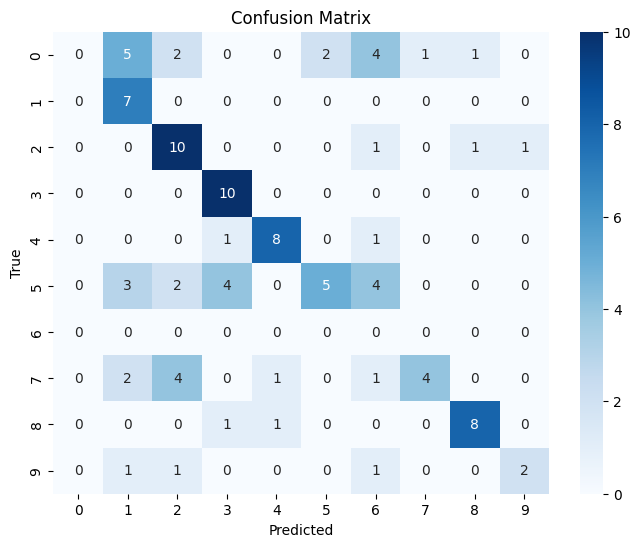

In [47]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [48]:
import bitsandbytes as bnb

def find_all_linear_names(model):
    cls = bnb.nn.Linear4bit
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])
    if 'lm_head' in lora_module_names:  # needed for 16 bit
        lora_module_names.remove('lm_head')
    return list(lora_module_names)

In [49]:
modules = find_all_linear_names(model)
modules

['down_proj', 'v_proj', 'k_proj', 'up_proj', 'o_proj', 'q_proj', 'gate_proj']

In [50]:
output_dir="Qwen 2.5 7B model"

peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0,
    r=16,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=modules,
)

training_arguments = TrainingArguments(
    output_dir=output_dir,                    # directory to save and repository id
    num_train_epochs=1,                       # number of training epochs
    per_device_train_batch_size=1,            # batch size per device during training
    gradient_accumulation_steps=8,            # number of steps before performing a backward/update pass
    gradient_checkpointing=True,              # use gradient checkpointing to save memory
    optim="paged_adamw_32bit",
    logging_steps=1,                         
    learning_rate=2e-4,                       # learning rate, based on QLoRA paper
    weight_decay=0.001,
    fp16=True,
    bf16=False,
    max_grad_norm=0.3,                        # max gradient norm based on QLoRA paper
    max_steps=-1,
    warmup_ratio=0.03,                        # warmup ratio based on QLoRA paper
    group_by_length=False,
    lr_scheduler_type="cosine",               # use cosine learning rate scheduler
    report_to="wandb",                  # report metrics to w&b
    eval_strategy="steps",              # save checkpoint every epoch
    eval_steps = 0.2
)

trainer = SFTTrainer(
    model=model,
    args=training_arguments,
    train_dataset=train_data,
    eval_dataset=val_data,
    peft_config=peft_config,
    dataset_text_field="text",
    tokenizer=tokenizer,
    max_seq_length=256,
    packing=False,
    dataset_kwargs={
    "add_special_tokens": False,
    "append_concat_token": False,
    }
)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field, max_seq_length, dataset_kwargs. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:283: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:321: UserWarning: You passed a `dataset_text_field` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:327: UserWarning: You passed a `dataset_kwargs` argument to the SFTTrainer, the value you pass

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [51]:
# Train model
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/opt/conda/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(),

Step,Training Loss,Validation Loss
20,0.885900,0.951847
40,0.896900,0.927783
60,0.947300,0.911426
80,0.889800,0.904740
100,0.840400,0.903410


TrainOutput(global_step=100, training_loss=0.9673243343830109, metrics={'train_runtime': 2080.4516, 'train_samples_per_second': 0.385, 'train_steps_per_second': 0.048, 'total_flos': 8732053101499392.0, 'train_loss': 0.9673243343830109, 'epoch': 1.0})

In [52]:
wandb.finish()
model.config.use_cache = True

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:               eval/loss █▅▂▁▁
wandb:            eval/runtime █▄▁▂▃
wandb: eval/samples_per_second ▁▆██▆
wandb:   eval/steps_per_second ▁▁▁▁▁
wandb:             train/epoch ▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇████
wandb:       train/global_step ▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
wandb:         train/grad_norm █▆▅▅▄▃▅▁▁▁▁▁▁▁▂▁▁▁▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▃▂▂▂▂▂▂
wandb:     train/learning_rate ████████▇▇▇▇▆▆▆▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
wandb:              train/loss █▆▄▃▃▃▂▂▂▃▃▂▂▁▂▂▂▂▂▃▁▂▂▁▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁
wandb: 
wandb: Run summary:
wandb:                eval/loss 0.90341
wandb:             eval/runtime 54.5772
wandb:  eval/samples_per_second 1.832
wandb:    eval/steps_per_second 0.238
wandb:               total_flos 8732053101499392.0
wandb:              train/epoch 1
wandb:        train/global_step 100
wandb:          train/grad_norm 0.36768
wandb:      train/learning_rate 

In [53]:
#Save Train Model and Tokenizer
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)

('Qwen 2.5 7B model/tokenizer_config.json',
 'Qwen 2.5 7B model/special_tokens_map.json',
 'Qwen 2.5 7B model/vocab.json',
 'Qwen 2.5 7B model/merges.txt',
 'Qwen 2.5 7B model/added_tokens.json',
 'Qwen 2.5 7B model/tokenizer.json')

In [54]:
y_pred = predict(X_test, model, tokenizer)

100%|██████████| 100/100 [08:46<00:00,  5.26s/it]


In [55]:
evaluate(y_true, y_pred)

Accuracy: 0.520
Accuracy for label bangladesh: 0.000
Accuracy for label sports: 0.900
Accuracy for label technology: 0.400
Accuracy for label entertainment: 1.000
Accuracy for label international: 0.200
Accuracy for label economy: 0.714
Accuracy for label life-style: 0.111
Accuracy for label opinion: 0.917
Accuracy for label education: 0.846

Classification Report:
               precision    recall  f1-score   support

   bangladesh       0.00      0.00      0.00        15
       sports       0.90      0.90      0.90        10
   technology       1.00      0.40      0.57         5
entertainment       0.26      1.00      0.41        10
international       1.00      0.20      0.33        10
      economy       1.00      0.71      0.83         7
   life-style       1.00      0.11      0.20        18
      opinion       0.73      0.92      0.81        12
    education       0.44      0.85      0.58        13

     accuracy                           0.52       100
    macro avg       0.70 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


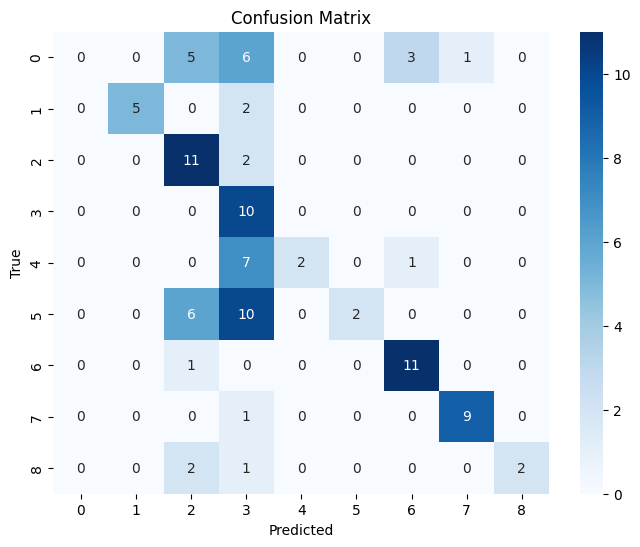

In [56]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()